<h1><center>SMS Spam Collection : ML Modeling</center></h1>
<hr>

In [1]:
import pandas as pd
import numpy as np
import re
import os
import scipy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from sklearn.naive_bayes  import GaussianNB, MultinomialNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier
from sklearn.calibration  import CalibratedClassifierCV
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('./sms_spam_collection_filtered.csv', encoding = "ISO-8859-1")

In [3]:
data.head()

,filtered_text,Label,text_length,presence_of_digit
0,go until jurong point crazy available only in ...,0,20,0
1,ok lar joking wif u oni,0,6,0
2,free entry in 2 a wkly comp to win fa cup fina...,1,30,4
3,u dun say so early hor u c already then say,0,11,0
4,nah i do not think he goes to usf he lives aro...,0,14,0


In [4]:
print("Presence of NULL records : ")
data.isna().sum()

Presence of NULL records : 


filtered_text        3
Label                0
text_length          0
presence_of_digit    0
dtype: int64

In [5]:
data = data.fillna(' ', axis=1)

In [6]:
print("Presence of NULL records : ")
data.isna().sum()

Presence of NULL records : 


filtered_text        0
Label                0
text_length          0
presence_of_digit    0
dtype: int64

# [1] Text Vectorization

<p>Before we could start vectorizing text data, let's split the data into Train, Cross Validation and Test to avoid Data Leakage</p>

## [1.1] Data Splitting

In [7]:
x_tr, x_te, y_tr, y_te = train_test_split(data.drop('Label', axis=1), data['Label'], stratify=data['Label'], \
                                         test_size=0.10, random_state=47)

x_tr, x_cv, y_tr, y_cv = train_test_split(x_tr, y_tr, stratify=y_tr, test_size=0.20, random_state=47)

print("Train Data : ", x_tr.shape)
print("CV    Data : ", x_cv.shape)
print("Test  Data : ", x_te.shape)

Train Data :  (4011, 3)
CV    Data :  (1003, 3)
Test  Data :  (558, 3)


## [1.2] Binary Vectorization

#### Uni-gram BoW

In [8]:
#unigram bag of words
bow        = CountVectorizer(min_df=5)
bow.fit(x_tr['filtered_text'].values)
bow_uni_tr = bow.transform(x_tr['filtered_text'].values)
bow_uni_cv = bow.transform(x_cv['filtered_text'].values)
bow_uni_te = bow.transform(x_te['filtered_text'].values)

bow_uni_features = bow.get_feature_names()

print("Number of Uni-grams with Filtered SMS text is >>>\n* Train data {0}\n* CV    data {1}\n* Test  data {2}."\
      .format(bow_uni_tr.shape, bow_uni_cv.shape, bow_uni_te.shape))

Number of Uni-grams with Filtered SMS text is >>>
* Train data (4011, 1408)
* CV    data (1003, 1408)
* Test  data (558, 1408).


#### Bi-gram BoW

In [9]:
#bigram bag of words
bow = CountVectorizer(min_df=5, ngram_range=(1, 2))
bow.fit(x_tr['filtered_text'].values)
bow_bi_tr = bow.transform(x_tr['filtered_text'].values)
bow_bi_cv = bow.transform(x_cv['filtered_text'].values)
bow_bi_te = bow.transform(x_te['filtered_text'].values)

bow_bi_features = bow.get_feature_names()

print("Number of B-grams with Filtered SMS text is >>>\n* Train data {0}\n* CV    data {1}\n* Test  data {2}."\
      .format(bow_bi_tr.shape, bow_bi_cv.shape, bow_bi_te.shape))

Number of B-grams with Filtered SMS text is >>>
* Train data (4011, 2734)
* CV    data (1003, 2734)
* Test  data (558, 2734).


## [1.3] TF-IDF vectorization

#### Uni-gram TF-IDF

In [10]:
#unigram bag of words
tfidf = TfidfVectorizer(min_df=5)
tfidf.fit(x_tr['filtered_text'].values)
tfidf_uni_tr = tfidf.transform(x_tr['filtered_text'].values)
tfidf_uni_cv = tfidf.transform(x_cv['filtered_text'].values)
tfidf_uni_te = tfidf.transform(x_te['filtered_text'].values)

tfidf_uni_features = tfidf.get_feature_names()

print("Number of Uni-grams with Filtered SMS text is >>>\n* Train data {0}\n* CV    data {1}\n* Test  data {2}."\
      .format(tfidf_uni_tr.shape, tfidf_uni_cv.shape, tfidf_uni_te.shape))

Number of Uni-grams with Filtered SMS text is >>>
* Train data (4011, 1408)
* CV    data (1003, 1408)
* Test  data (558, 1408).


#### Bi-gram TF-IDF

In [11]:
#bigram bag of words
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
tfidf.fit(x_tr['filtered_text'].values)
tfidf_bi_tr = tfidf.transform(x_tr['filtered_text'].values)
tfidf_bi_cv = tfidf.transform(x_cv['filtered_text'].values)
tfidf_bi_te = tfidf.transform(x_te['filtered_text'].values)

tfidf_bi_features = tfidf.get_feature_names()

print("Number of Bi-grams with Filtered SMS text is >>>\n* Train data {0}\n* CV    data {1}\n* Test  data {2}."\
      .format(tfidf_bi_tr.shape, tfidf_bi_cv.shape, tfidf_bi_te.shape))

Number of Bi-grams with Filtered SMS text is >>>
* Train data (4011, 2734)
* CV    data (1003, 2734)
* Test  data (558, 2734).


## [1.4] Word Vectorizer

In [12]:
w2v_dim = 100

### [1.4.1] Avg. Word2Vector

In [13]:
text_corpus = list()
for sent in tqdm(x_tr['filtered_text'].values):
    text_corpus.append(sent.split())

#text word2vec
text_w2v = Word2Vec(text_corpus, min_count=5, size=w2v_dim, workers=4)

100%|██████████████████████████████████████████████████████████████████████████| 4011/4011 [00:00<00:00, 235776.40it/s]


In [14]:
def text_to_w2v(X):
    word2vec = list()
    for sent in (X['filtered_text'].values):
        temp = np.zeros(w2v_dim)
        word_count = 0
        for word in sent.split():
            try:
                vect = text_w2v.wv[word]
            except KeyError:
                vect = np.zeros(w2v_dim)
            except Exception as e:
                print(e)
            temp += vect
            word_count += 1
        if word_count != 0:
            temp /= word_count
        else:
            temp = np.zeros(w2v_dim)
        word2vec.append(temp)
    return word2vec

In [15]:
#word2vec for sms text
w2v_tr = text_to_w2v(x_tr)
w2v_cv = text_to_w2v(x_cv)
w2v_te = text_to_w2v(x_te)

print("Text Vector for >>>\n* Train data is {0}\n* CV    data is {1}\n* Test  data is {2}."\
      .format(len(w2v_tr), len(w2v_cv), len(w2v_te)))

Text Vector for >>>
* Train data is 4011
* CV    data is 1003
* Test  data is 558.


### [1.4.2] TF-IDF Word2Vec

In [16]:
#train text corpus
text_corpus = list()
for sent in tqdm(x_tr['filtered_text'].values):
    text_corpus.append(sent.split())

#text word2vec
text_tfidfw2v = Word2Vec(text_corpus, min_count=5, size=w2v_dim, workers=4)


#processed review text
tfidfw2v           = TfidfVectorizer(min_df=5)
tfidfw2v_text      = tfidfw2v.fit_transform(x_tr['filtered_text'].values)
tfidfw2v_text_dict = dict(list(zip(tfidfw2v.get_feature_names(), tfidfw2v.idf_)))

100%|██████████████████████████████████████████████████████████████████████████| 4011/4011 [00:00<00:00, 308679.72it/s]


In [17]:
def text_to_tfidfw2v(X):
    tfidf_vector = list()
    for sent in X['filtered_text'].values:
        temp      = np.zeros(w2v_dim)
        tfidf_val = 0
        for word in sent.split():
            try:
                w_tfidf = tfidfw2v_text_dict[word]
            except KeyError:
                w_tfidf = 0
            try:
                vect = text_tfidfw2v.wv[word]
            except KeyError:
                vect = np.zeros(w2v_dim)
            temp      += ( w_tfidf * vect )
            tfidf_val += w_tfidf
        if tfidf_val != 0:
            temp /= tfidf_val
        else:
            temp = np.zeros(w2v_dim)
        tfidf_vector.append(temp)
    return tfidf_vector

In [18]:
#word2vec for sms text
tfidfw2v_tr = text_to_tfidfw2v(x_tr)
tfidfw2v_cv = text_to_tfidfw2v(x_cv)
tfidfw2v_te = text_to_tfidfw2v(x_te)

print("Text Vector for >>>\n* Train data is {0}\n* CV    data is {1}\n* Test  data is {2}."\
      .format(len(tfidfw2v_tr), len(tfidfw2v_cv), len(tfidfw2v_te)))

Text Vector for >>>
* Train data is 4011
* CV    data is 1003
* Test  data is 558.


<hr>

# [2] Data Combining

In [19]:
#data standardization of categorical features
std       = StandardScaler()
std.fit(x_tr[['text_length', 'presence_of_digit']])

norm_x_tr = std.transform(x_tr[['text_length', 'presence_of_digit']])
norm_x_cv = std.transform(x_cv[['text_length', 'presence_of_digit']])
norm_x_te = std.transform(x_te[['text_length', 'presence_of_digit']])

In [20]:
#uni-gram bow_features
x_tr_bow_uni     = scipy.sparse.csr_matrix(np.hstack((norm_x_tr, bow_uni_tr.toarray())))
x_cv_bow_uni     = scipy.sparse.csr_matrix(np.hstack((norm_x_cv, bow_uni_cv.toarray())))
x_te_bow_uni     = scipy.sparse.csr_matrix(np.hstack((norm_x_te, bow_uni_te.toarray())))
uni_bow_features = list(np.hstack((['text_length', 'presence_of_digit'], bow_uni_features)))

#bi-gram bow_features
x_tr_bow_bi     = scipy.sparse.csr_matrix(np.hstack((norm_x_tr, bow_bi_tr.toarray())))
x_cv_bow_bi     = scipy.sparse.csr_matrix(np.hstack((norm_x_cv, bow_bi_cv.toarray())))
x_te_bow_bi     = scipy.sparse.csr_matrix(np.hstack((norm_x_te, bow_bi_te.toarray())))
bi_bow_features = list(np.hstack((['text_length', 'presence_of_digit'], bow_bi_features)))

In [21]:
#uni-gram tfidf_features
x_tr_tfidf_uni     = scipy.sparse.csr_matrix(np.hstack((norm_x_tr, tfidf_uni_tr.toarray())))
x_cv_tfidf_uni     = scipy.sparse.csr_matrix(np.hstack((norm_x_cv, tfidf_uni_cv.toarray())))
x_te_tfidf_uni     = scipy.sparse.csr_matrix(np.hstack((norm_x_te, tfidf_uni_te.toarray())))
uni_tfidf_features = list(np.hstack((['text_length', 'presence_of_digit'], tfidf_uni_features)))

#bi-gram tfidf_features
x_tr_tfidf_bi     = scipy.sparse.csr_matrix(np.hstack((norm_x_tr, tfidf_bi_tr.toarray())))
x_cv_tfidf_bi     = scipy.sparse.csr_matrix(np.hstack((norm_x_cv, tfidf_bi_cv.toarray())))
x_te_tfidf_bi     = scipy.sparse.csr_matrix(np.hstack((norm_x_te, tfidf_bi_te.toarray())))
bi_tfidf_features = list(np.hstack((['text_length', 'presence_of_digit'], tfidf_bi_features)))

In [22]:
#avg word2vec features
x_tr_w2v = np.hstack((norm_x_tr, w2v_tr))
x_cv_w2v = np.hstack((norm_x_cv, w2v_cv))
x_te_w2v = np.hstack((norm_x_te, w2v_te))
w2v_features = list(np.hstack((['text_length', 'presence_of_digit'], \
                               ['w2v_dim_'+str(i).rjust(len(str(w2v_dim)), '0') for i in range(1, w2v_dim+1)])))

In [23]:
#tfidf word2vec features
x_tr_tfidfw2v     = np.hstack((norm_x_tr, tfidfw2v_tr))
x_cv_tfidfw2v     = np.hstack((norm_x_cv, tfidfw2v_cv))
x_te_tfidfw2v     = np.hstack((norm_x_te, tfidfw2v_te))
tfidfw2v_features = list(np.hstack((['text_length', 'presence_of_digit'], \
                                    ['tfidfw2v_dim_'+str(i).rjust(len(str(w2v_dim)), '0') for i in range(1, w2v_dim+1)])))

<hr>

# [3] Modeling

In [24]:
model_performances = dict()

#hyper_parameters
knn_neighbors = [ x for x in range(1, 50) if ((x%2!= 0)and (x%3!=0)) ]
#knn_neighbors = [5, 11, 15, 21, 31, 41, 51, 99]
print("Neighbors list     : ", knn_neighbors)

alpha_range = [ 10**i for i in range(-6, 4) ]
print("Alpha Range list   : ", alpha_range)

base_trees = [ 20, 50, 100, 200, 400, 600, 800, 1000 ]
print("Base Tree Learners : ", base_trees)

#class weights
labels = data['Label']
weight_0 = len([ x for x in labels if x==0 ])/data.shape[0]
weight_1 = len([ x for x in labels if x==1 ])/data.shape[0]

Neighbors list     :  [1, 5, 7, 11, 13, 17, 19, 23, 25, 29, 31, 35, 37, 41, 43, 47, 49]
Alpha Range list   :  [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
Base Tree Learners :  [20, 50, 100, 200, 400, 600, 800, 1000]


In [25]:
def plot_confusion_matrix(actual, predicted, predicted_probs):
    """
    for plotting confusion matrix for predicted and actual class labels
    """
    C = confusion_matrix(actual, predicted) #confusion matrix
    A = ((C.T)/(C.sum(axis=1))).T           #recall matrix    (row sum=1)
    B = (C/C.sum(axis=0))                   #precision matrix (col sum=1)
    labels = list(range(2))
    
    plt.figure(figsize=(10, 5))
    fpr, tpr, _ = roc_curve(actual, predicted_probs)
    plt.plot(fpr, tpr, label='CV AUC', lw=1.5)
    plt.plot([0, 1], [0, 1], lw=2)
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross Validation AUC')
    plt.grid()

    plt.figure(figsize=(15, 5))
    ax1=plt.subplot(131)
    #print('-'*10, 'Confusion Matrix', '-'*10)
    #plt.figure(figsize=(5, 4))
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    ax2=plt.subplot(132)
    #print('-'*10, 'Precision Matrix (ColSum=1)', '-'*10)#B
    #plt.figure(figsize=(5, 4))
    sns.heatmap(B, annot=True, cmap='YlGn', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_title('Precision Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    ax3=plt.subplot(133)
    #print('-'*10, 'Recall Matrix (RowSum=1)', '-'*10)#A
    #plt.figure(figsize=(5, 4))
    sns.heatmap(A, annot=True, cmap='YlOrBr', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax3)
    ax3.set_title('Recall Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    plt.tight_layout()
    plt.show()

## [3.1] Naive Bayes 

In [26]:
def naive_bayes_model(train, Y_train, cv, Y_cv, alpha_value):
    nb_clf      = MultinomialNB(alpha=alpha_value)
    nb_clf.fit(train, Y_train)
    pred        = nb_clf.predict(cv)
    auc_score   = roc_auc_score(Y_cv, pred)
    return (nb_clf, pred, auc_score)

#### [3.1.1] Naive Bayes : Uni-gram Bag of Words

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.96928
Alpha=1e-05  :: AUC=0.96928
Alpha=0.0001 :: AUC=0.97301
Alpha=0.001  :: AUC=0.97301
Alpha=0.01   :: AUC=0.97043
Alpha=0.1    :: AUC=0.96985
Alpha=1      :: AUC=0.96698
Alpha=10     :: AUC=0.90872
Alpha=100    :: AUC=0.50000
Alpha=1000   :: AUC=0.50000


Best auc was found to be for Alpha=0.0001, with value to be 0.97301

Test AUC=0.98000 for Alpha=0.0001


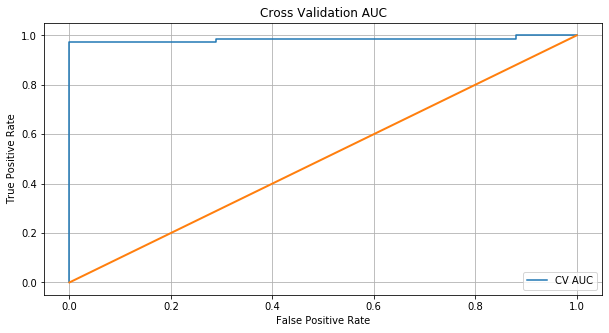

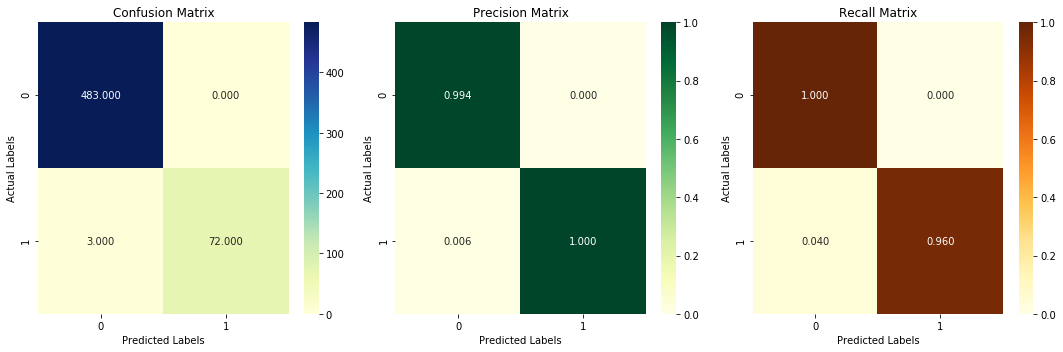

Important features are : 
Feature  ::  text_length
Feature  ::  presence_of_digit
Feature  ::  to
Feature  ::  call
Feature  ::  and
Feature  ::  you
Feature  ::  your
Feature  ::  free
Feature  ::  the
Feature  ::  now


In [27]:
X_tr = scipy.sparse.csr_matrix(np.hstack((x_tr[['text_length', 'presence_of_digit']], bow_uni_tr.toarray())))
X_cv = scipy.sparse.csr_matrix(np.hstack((x_cv[['text_length', 'presence_of_digit']], bow_uni_cv.toarray())))
X_te = scipy.sparse.csr_matrix(np.hstack((x_te[['text_length', 'presence_of_digit']], bow_uni_te.toarray())))

cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = naive_bayes_model(X_tr, y_tr, X_tr, y_tr, best_alpha)
_  , _      , cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, best_alpha)
clf, te_pred, te_auc = naive_bayes_model(X_tr, y_tr, X_te, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Naive Bayes (Uni-BOW)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(X_te)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(uni_bow_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.1.2] Naive Bayes : Bi-gram Bag of Words

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.95923
Alpha=1e-05  :: AUC=0.95923
Alpha=0.0001 :: AUC=0.96297
Alpha=0.001  :: AUC=0.96297
Alpha=0.01   :: AUC=0.96354
Alpha=0.1    :: AUC=0.96727
Alpha=1      :: AUC=0.96612
Alpha=10     :: AUC=0.86567
Alpha=100    :: AUC=0.50000
Alpha=1000   :: AUC=0.50000


Best auc was found to be for Alpha=0.1, with value to be 0.96727

Test AUC=0.99126 for Alpha=0.1   


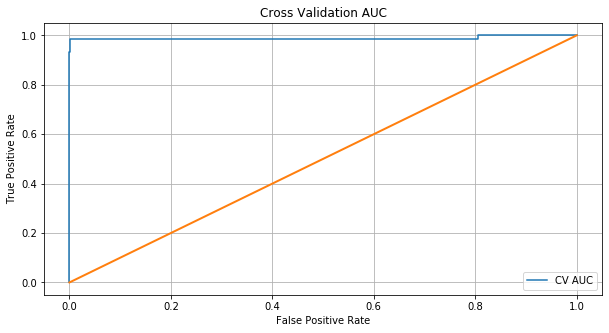

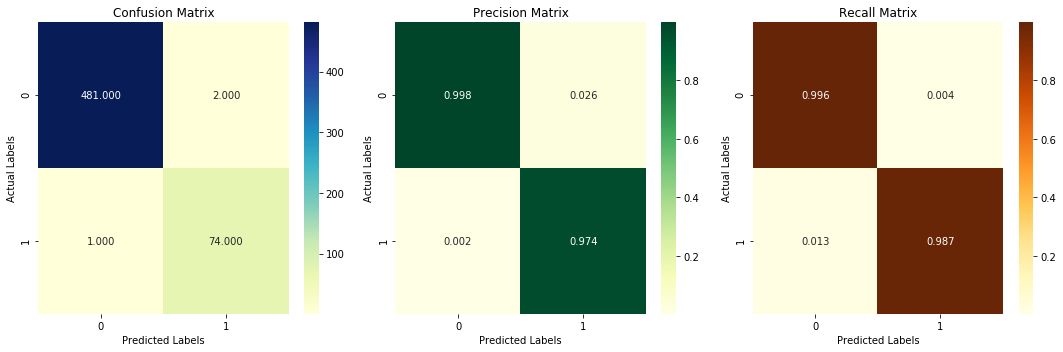

Important features are : 
Feature  ::  text_length
Feature  ::  presence_of_digit
Feature  ::  to
Feature  ::  call
Feature  ::  and
Feature  ::  you
Feature  ::  your
Feature  ::  free
Feature  ::  the
Feature  ::  now


In [28]:
X_tr = scipy.sparse.csr_matrix(np.hstack((x_tr[['text_length', 'presence_of_digit']], bow_bi_tr.toarray())))
X_cv = scipy.sparse.csr_matrix(np.hstack((x_cv[['text_length', 'presence_of_digit']], bow_bi_cv.toarray())))
X_te = scipy.sparse.csr_matrix(np.hstack((x_te[['text_length', 'presence_of_digit']], bow_bi_te.toarray())))

cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = naive_bayes_model(X_tr, y_tr, X_tr, y_tr, best_alpha)
_  , _      , cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, best_alpha)
clf, te_pred, te_auc = naive_bayes_model(X_tr, y_tr, X_te, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Naive Bayes (Bi-BOW)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(X_te)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(bi_bow_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.1.3] Naive Bayes : Uni-gram Tf-IDF Vectorizer

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.96412
Alpha=1e-05  :: AUC=0.96785
Alpha=0.0001 :: AUC=0.96785
Alpha=0.001  :: AUC=0.97215
Alpha=0.01   :: AUC=0.96670
Alpha=0.1    :: AUC=0.95866
Alpha=1      :: AUC=0.92335
Alpha=10     :: AUC=0.59960
Alpha=100    :: AUC=0.50000
Alpha=1000   :: AUC=0.50000


Best auc was found to be for Alpha=0.001, with value to be 0.97215

Test AUC=0.98460 for Alpha=0.001 


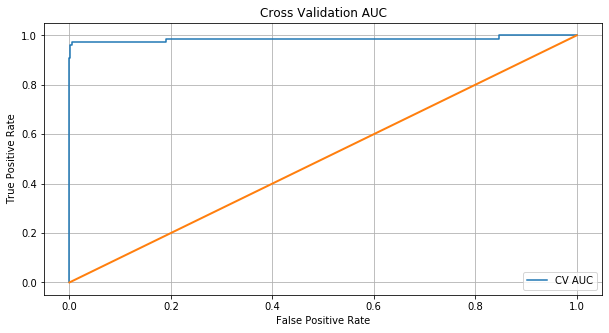

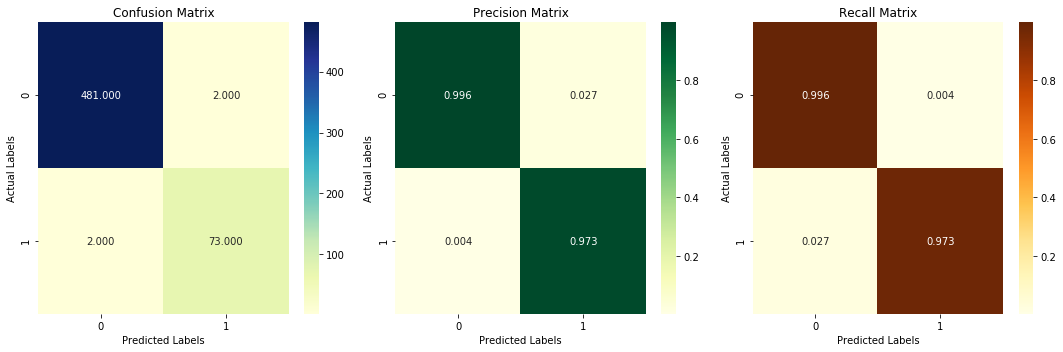

Important features are : 
Feature  ::  00
Feature  ::  000
Feature  ::  today
Feature  ::  called
Feature  ::  freephone
Feature  ::  yourself
Feature  ::  another
Feature  ::  yours
Feature  ::  ntt
Feature  ::  txts


In [29]:
X_tr = scipy.sparse.csr_matrix(np.hstack((x_tr[['text_length', 'presence_of_digit']], tfidf_uni_tr.toarray())))
X_cv = scipy.sparse.csr_matrix(np.hstack((x_cv[['text_length', 'presence_of_digit']], tfidf_uni_cv.toarray())))
X_te = scipy.sparse.csr_matrix(np.hstack((x_te[['text_length', 'presence_of_digit']], tfidf_uni_te.toarray())))

cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = naive_bayes_model(X_tr, y_tr, X_tr, y_tr, best_alpha)
_  , _      , cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, best_alpha)
clf, te_pred, te_auc = naive_bayes_model(X_tr, y_tr, X_te, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Naive Bayes (Uni-TF-IDF)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(X_te)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(tfidf_uni_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.1.4] Naive Bayes : Bi-gram Tf-IDF Vectorizer

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.96096
Alpha=1e-05  :: AUC=0.96154
Alpha=0.0001 :: AUC=0.96469
Alpha=0.001  :: AUC=0.96842
Alpha=0.01   :: AUC=0.96297
Alpha=0.1    :: AUC=0.96239
Alpha=1      :: AUC=0.92565
Alpha=10     :: AUC=0.51493
Alpha=100    :: AUC=0.50000
Alpha=1000   :: AUC=0.50000


Best auc was found to be for Alpha=0.001, with value to be 0.96842

Test AUC=0.98460 for Alpha=0.001 


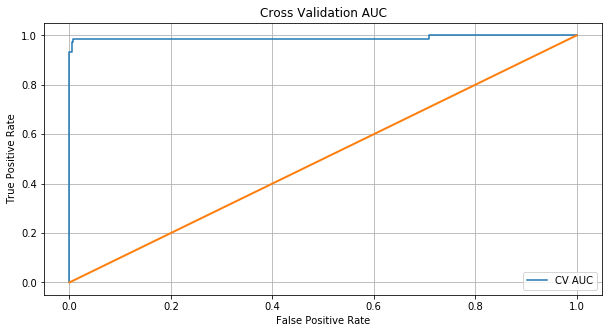

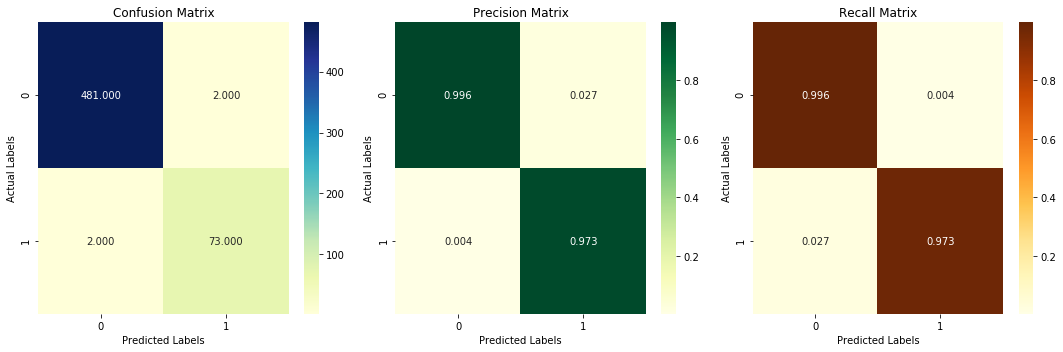

Important features are : 
Feature  ::  00
Feature  ::  000
Feature  ::  to 82277
Feature  ::  call 08712460324
Feature  ::  free camcorder
Feature  ::  your ass
Feature  ::  and amp
Feature  ::  txt music
Feature  ::  now am
Feature  ::  you already


In [30]:
X_tr = scipy.sparse.csr_matrix(np.hstack((x_tr[['text_length', 'presence_of_digit']], tfidf_bi_tr.toarray())))
X_cv = scipy.sparse.csr_matrix(np.hstack((x_cv[['text_length', 'presence_of_digit']], tfidf_bi_cv.toarray())))
X_te = scipy.sparse.csr_matrix(np.hstack((x_te[['text_length', 'presence_of_digit']], tfidf_bi_te.toarray())))

cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = naive_bayes_model(X_tr, y_tr, X_tr, y_tr, best_alpha)
_  , _      , cv_auc = naive_bayes_model(X_tr, y_tr, X_cv, y_cv, best_alpha)
clf, te_pred, te_auc = naive_bayes_model(X_tr, y_tr, X_te, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Naive Bayes (Bi-TFIDF)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(X_te)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(tfidf_bi_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

In [31]:
from prettytable import PrettyTable
nb = PrettyTable(['Model', 'Best Hyper-parameter', 'Train AUC', 'CV AUC', 'Test AUC'])
for k, v in model_performances.items():
    if k.startswith('Naive'):
        nb.add_row([k, v[0], round(v[1], 5), round(v[2], 5), round(v[3], 5)])
    
print(nb)

+--------------------------+----------------------+-----------+---------+----------+
|          Model           | Best Hyper-parameter | Train AUC |  CV AUC | Test AUC |
+--------------------------+----------------------+-----------+---------+----------+
|  Naive Bayes (Uni-BOW)   |        0.0001        |  0.98018  | 0.97301 |   0.98   |
|   Naive Bayes (Bi-BOW)   |         0.1          |  0.97461  | 0.96727 | 0.99126  |
| Naive Bayes (Uni-TF-IDF) |        0.001         |  0.97031  | 0.97215 |  0.9846  |
|  Naive Bayes (Bi-TFIDF)  |        0.001         |  0.97425  | 0.96842 |  0.9846  |
+--------------------------+----------------------+-----------+---------+----------+


<p><b>Conclusion : Naive Bayes Model</b></p>

<p>From above AUC plots and Confusion MAtrics, we can see that Naive bayes model performs better on complete data. With AUC score more that 0.98 is obtained in both BoW and TF-IDF vectorization techniques.</p>
<p>Bi-gram Bag of Words with Naive Bayes performs better with test data with over 0.99 AUC value.</p>

## [3.2] Logistic Regression

In [32]:
def log_reg_model(train, Y_train, cv, Y_cv, alpha_value):
    lr_clf      = SGDClassifier(loss='log', penalty='l2', alpha=alpha_value, random_state=27)
    lr_clf.fit(train, Y_train)
    pred        = lr_clf.predict(cv)
    auc_score   = roc_auc_score(Y_cv, pred)
    return (lr_clf, pred, auc_score)

#### [3.2.1] Logistic Regression : Uni-gram BoW

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.96181
Alpha=1e-05  :: AUC=0.96039
Alpha=0.0001 :: AUC=0.96842
Alpha=0.001  :: AUC=0.96354
Alpha=0.01   :: AUC=0.91646
Alpha=0.1    :: AUC=0.88086
Alpha=1      :: AUC=0.84267
Alpha=10     :: AUC=0.81197
Alpha=100    :: AUC=0.75171
Alpha=1000   :: AUC=0.54047


Best auc was found to be for Alpha=0.0001, with value to be 0.96842

Test AUC=0.97275 for Alpha=0.0001


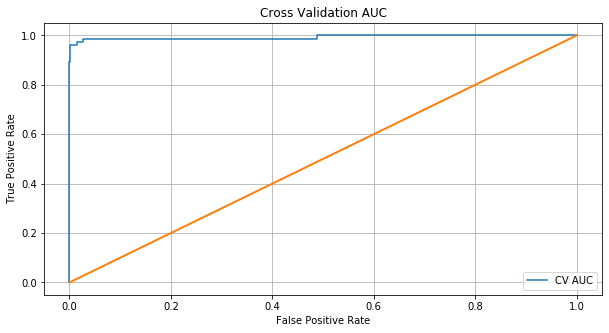

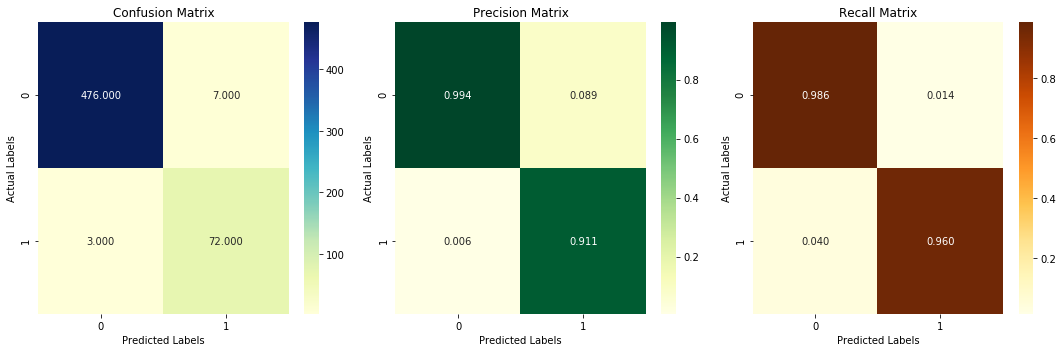

Important features are : 
Feature  ::  ringtone
Feature  ::  text
Feature  ::  sale
Feature  ::  ltd
Feature  ::  presence_of_digit
Feature  ::  txt
Feature  ::  new
Feature  ::  comes
Feature  ::  won
Feature  ::  girls


In [33]:
cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = log_reg_model(x_tr_bow_uni, y_tr, x_cv_bow_uni, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = log_reg_model(x_tr_bow_uni, y_tr, x_tr_bow_uni, y_tr, best_alpha)
_  , _      , cv_auc = log_reg_model(x_tr_bow_uni, y_tr, x_cv_bow_uni, y_cv, best_alpha)
clf, te_pred, te_auc = log_reg_model(x_tr_bow_uni, y_tr, x_te_bow_uni, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Log-Reg (Uni-BoW)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_bow_uni)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(uni_bow_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.2.2] Logistic Regression : Bi-gram BoW

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.96583
Alpha=1e-05  :: AUC=0.95808
Alpha=0.0001 :: AUC=0.96842
Alpha=0.001  :: AUC=0.95665
Alpha=0.01   :: AUC=0.92823
Alpha=0.1    :: AUC=0.88459
Alpha=1      :: AUC=0.85444
Alpha=10     :: AUC=0.81628
Alpha=100    :: AUC=0.75171
Alpha=1000   :: AUC=0.54047


Best auc was found to be for Alpha=0.0001, with value to be 0.96842

Test AUC=0.97275 for Alpha=0.0001


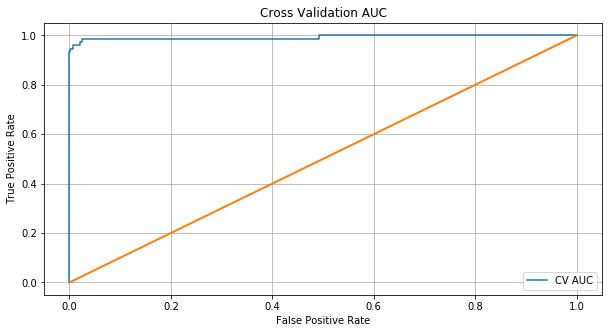

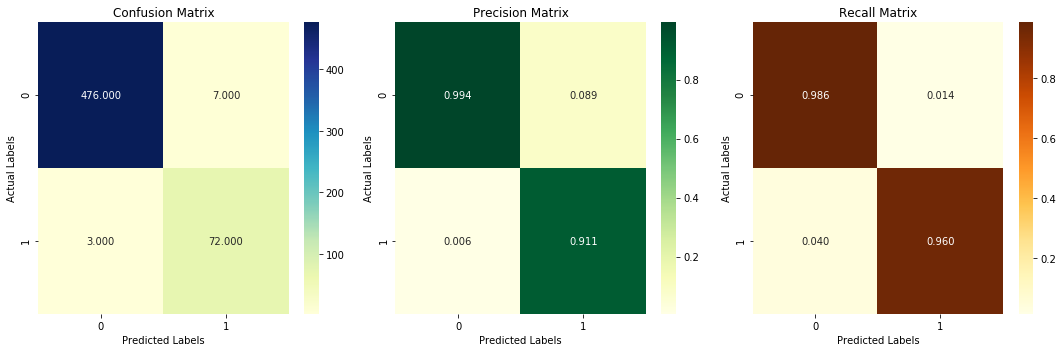

Important features are : 
Feature  ::  text
Feature  ::  ringtone
Feature  ::  text_length
Feature  ::  presence_of_digit
Feature  ::  txt
Feature  ::  sale
Feature  ::  but no
Feature  ::  lost
Feature  ::  enjoy
Feature  ::  we will


In [34]:
cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = log_reg_model(x_tr_bow_bi, y_tr, x_cv_bow_bi, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = log_reg_model(x_tr_bow_bi, y_tr, x_tr_bow_bi, y_tr, best_alpha)
_  , _      , cv_auc = log_reg_model(x_tr_bow_bi, y_tr, x_cv_bow_bi, y_cv, best_alpha)
clf, te_pred, te_auc = log_reg_model(x_tr_bow_bi, y_tr, x_te_bow_bi, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Log-Reg (Bi-BoW)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_bow_bi)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(bi_bow_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.2.3] Logistic Regression : Uni-gram TF-IDF

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.95866
Alpha=1e-05  :: AUC=0.96670
Alpha=0.0001 :: AUC=0.94546
Alpha=0.001  :: AUC=0.85361
Alpha=0.01   :: AUC=0.86020
Alpha=0.1    :: AUC=0.87392
Alpha=1      :: AUC=0.88937
Alpha=10     :: AUC=0.88937
Alpha=100    :: AUC=0.86618
Alpha=1000   :: AUC=0.56056


Best auc was found to be for Alpha=1e-05, with value to be 0.96670

Test AUC=0.97586 for Alpha=1e-05 


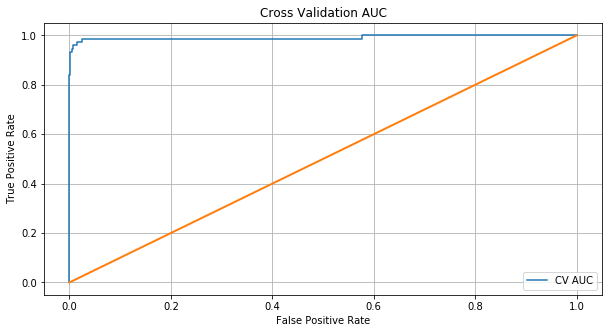

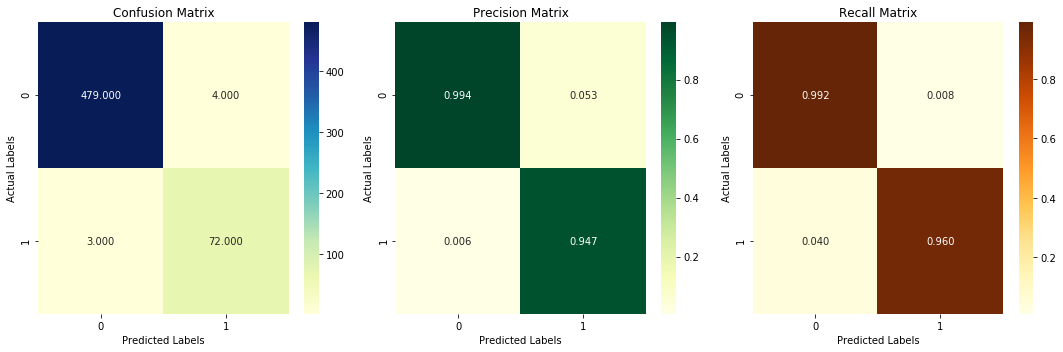

Important features are : 
Feature  ::  txt
Feature  ::  or
Feature  ::  text
Feature  ::  to
Feature  ::  free
Feature  ::  girls
Feature  ::  won
Feature  ::  for
Feature  ::  mobile
Feature  ::  new


In [35]:
cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = log_reg_model(x_tr_tfidf_uni, y_tr, x_cv_tfidf_uni, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = log_reg_model(x_tr_tfidf_uni, y_tr, x_tr_tfidf_uni, y_tr, best_alpha)
_  , _      , cv_auc = log_reg_model(x_tr_tfidf_uni, y_tr, x_cv_tfidf_uni, y_cv, best_alpha)
clf, te_pred, te_auc = log_reg_model(x_tr_tfidf_uni, y_tr, x_te_tfidf_uni, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Log-Reg (Uni-TF-IDF)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_tfidf_uni)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(uni_tfidf_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.2.4] Logistic Regression : Bi-gram TF-IDF

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.96785
Alpha=1e-05  :: AUC=0.94977
Alpha=0.0001 :: AUC=0.94488
Alpha=0.001  :: AUC=0.84987
Alpha=0.01   :: AUC=0.86020
Alpha=0.1    :: AUC=0.87392
Alpha=1      :: AUC=0.88937
Alpha=10     :: AUC=0.88822
Alpha=100    :: AUC=0.86503
Alpha=1000   :: AUC=0.56056


Best auc was found to be for Alpha=1e-06, with value to be 0.96785

Test AUC=0.97586 for Alpha=1e-06 


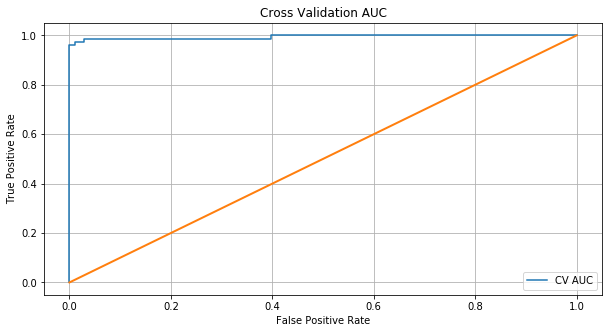

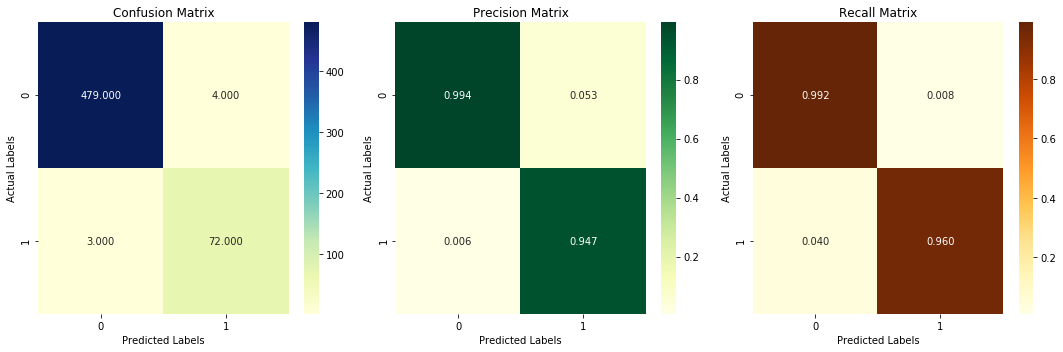

Important features are : 
Feature  ::  txt
Feature  ::  or
Feature  ::  free
Feature  ::  text
Feature  ::  call
Feature  ::  girls
Feature  ::  mobile
Feature  ::  from
Feature  ::  service
Feature  ::  to


In [36]:
cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = log_reg_model(x_tr_tfidf_bi, y_tr, x_cv_tfidf_bi, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = log_reg_model(x_tr_tfidf_bi, y_tr, x_tr_tfidf_bi, y_tr, best_alpha)
_  , _      , cv_auc = log_reg_model(x_tr_tfidf_bi, y_tr, x_cv_tfidf_bi, y_cv, best_alpha)
clf, te_pred, te_auc = log_reg_model(x_tr_tfidf_bi, y_tr, x_te_tfidf_bi, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Log-Reg (Bi-TF-IDF)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_tfidf_bi)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(bi_tfidf_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.2.5] Logistic Regression : Avg. Word2Vec

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.54736
Alpha=1e-05  :: AUC=0.89577
Alpha=0.0001 :: AUC=0.82431
Alpha=0.001  :: AUC=0.82719
Alpha=0.01   :: AUC=0.76318
Alpha=0.1    :: AUC=0.67823
Alpha=1      :: AUC=0.50000
Alpha=10     :: AUC=0.50000
Alpha=100    :: AUC=0.50000
Alpha=1000   :: AUC=0.50000


Best auc was found to be for Alpha=1e-05, with value to be 0.89577

Test AUC=0.90596 for Alpha=1e-05 


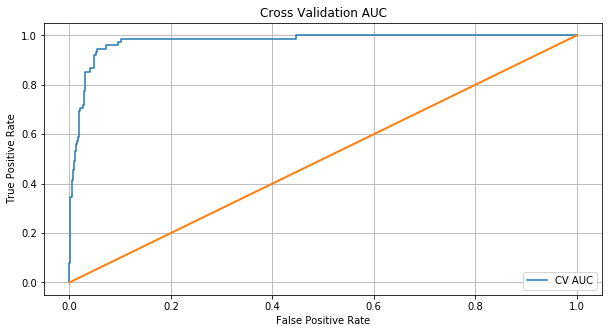

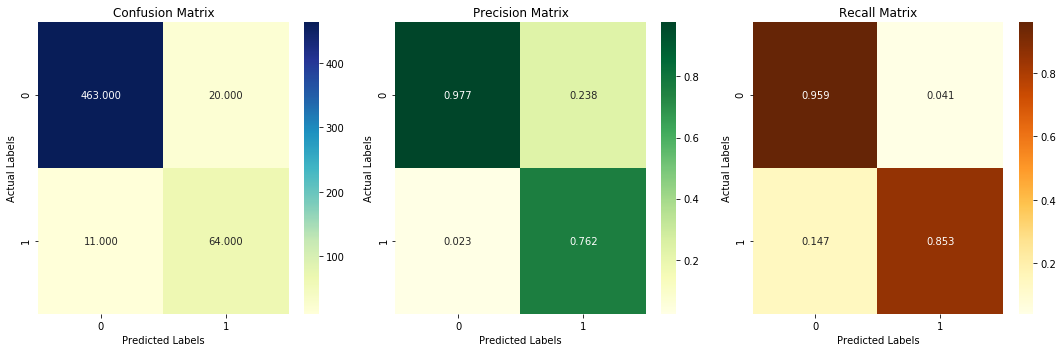

Important features are : 
Feature  ::  w2v_dim_036
Feature  ::  w2v_dim_096
Feature  ::  w2v_dim_065
Feature  ::  w2v_dim_060
Feature  ::  w2v_dim_017
Feature  ::  w2v_dim_084
Feature  ::  w2v_dim_022
Feature  ::  w2v_dim_050
Feature  ::  w2v_dim_054
Feature  ::  w2v_dim_083


In [37]:
cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = log_reg_model(x_tr_w2v, y_tr, x_cv_w2v, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = log_reg_model(x_tr_w2v, y_tr, x_tr_w2v, y_tr, best_alpha)
_  , _      , cv_auc = log_reg_model(x_tr_w2v, y_tr, x_cv_w2v, y_cv, best_alpha)
clf, te_pred, te_auc = log_reg_model(x_tr_w2v, y_tr, x_te_w2v, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Log-Reg (Avg. W2V)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_w2v)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(w2v_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.2.6] Logistic Regression : TF-IDF Word2Vec

Hyper-parameter Tuning : 
Alpha=1e-06  :: AUC=0.55913
Alpha=1e-05  :: AUC=0.89146
Alpha=0.0001 :: AUC=0.83636
Alpha=0.001  :: AUC=0.82288
Alpha=0.01   :: AUC=0.74998
Alpha=0.1    :: AUC=0.67823
Alpha=1      :: AUC=0.50000
Alpha=10     :: AUC=0.50000
Alpha=100    :: AUC=0.50000
Alpha=1000   :: AUC=0.50000


Best auc was found to be for Alpha=1e-05, with value to be 0.89146

Test AUC=0.91366 for Alpha=1e-05 


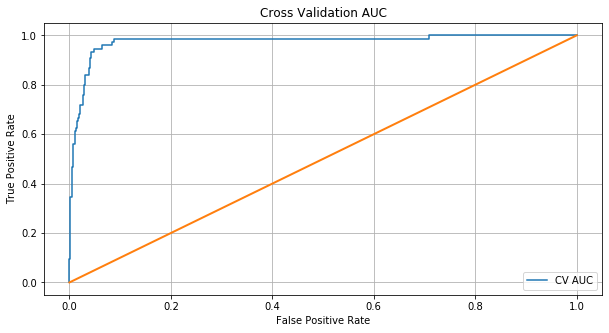

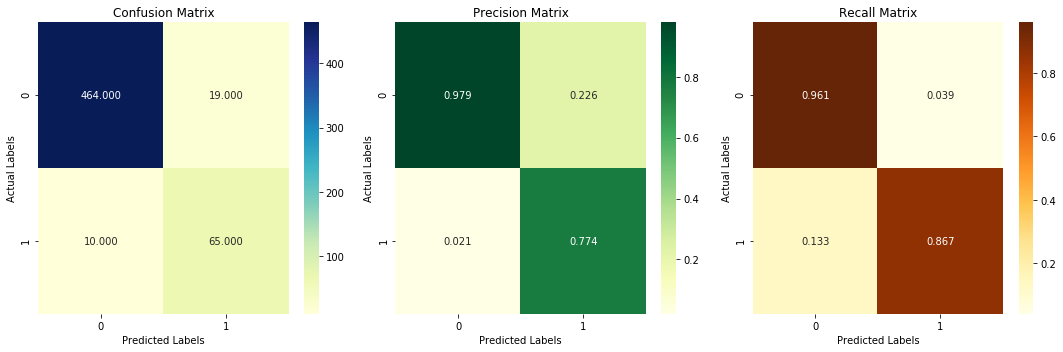

Important features are : 
Feature  ::  tfidfw2v_dim_036
Feature  ::  tfidfw2v_dim_060
Feature  ::  tfidfw2v_dim_065
Feature  ::  tfidfw2v_dim_096
Feature  ::  tfidfw2v_dim_022
Feature  ::  tfidfw2v_dim_054
Feature  ::  tfidfw2v_dim_050
Feature  ::  tfidfw2v_dim_017
Feature  ::  tfidfw2v_dim_067
Feature  ::  tfidfw2v_dim_041


In [38]:
cv_auc_score = list()
print("Hyper-parameter Tuning : ")
for alpha in alpha_range:
    _, _, cv_auc = log_reg_model(x_tr_tfidfw2v, y_tr, x_cv_tfidfw2v, y_cv, alpha)
    print("Alpha={0} :: AUC={1}".format(str(alpha).ljust(6, ' '), str(round(cv_auc, 5)).ljust(7, '0') ))
    cv_auc_score.append(cv_auc)
    
best_alpha = alpha_range[np.argmax(cv_auc_score)]
print("\n\nBest auc was found to be for Alpha={0}, with value to be {1}"\
      .format(best_alpha, str(round(max(cv_auc_score), 5)).ljust(7, '0') ))

_  , _      , tr_auc = log_reg_model(x_tr_tfidfw2v, y_tr, x_tr_tfidfw2v, y_tr, best_alpha)
_  , _      , cv_auc = log_reg_model(x_tr_tfidfw2v, y_tr, x_cv_tfidfw2v, y_cv, best_alpha)
clf, te_pred, te_auc = log_reg_model(x_tr_tfidfw2v, y_tr, x_te_tfidfw2v, y_te, best_alpha)
print("\nTest AUC={0} for Alpha={1}".format(  str(round(te_auc, 5)).ljust(7, '0'), str(best_alpha).ljust(6, ' ') ))
model_performances['Log-Reg (TF-IDF W2V)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_tfidfw2v)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(tfidfw2v_features, clf.coef_[0])).items()), reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

In [39]:
from prettytable import PrettyTable
lr = PrettyTable(['Model', 'Best Hyper-parameter', 'Train AUC', 'CV AUC', 'Test AUC'])
for k, v in list(model_performances.items())[4:]:
    if k.startswith('Log'):
        lr.add_row([k, v[0], round(v[1], 5), round(v[2], 5), round(v[3], 5)])
    
print(lr)

+----------------------+----------------------+-----------+---------+----------+
|        Model         | Best Hyper-parameter | Train AUC |  CV AUC | Test AUC |
+----------------------+----------------------+-----------+---------+----------+
|  Log-Reg (Uni-BoW)   |        0.0001        |  0.99521  | 0.96842 | 0.97275  |
|   Log-Reg (Bi-BoW)   |        0.0001        |  0.99628  | 0.96842 | 0.97275  |
| Log-Reg (Uni-TF-IDF) |        1e-05         |  0.99692  |  0.9667 | 0.97586  |
| Log-Reg (Bi-TF-IDF)  |        1e-06         |  0.99907  | 0.96785 | 0.97586  |
|  Log-Reg (Avg. W2V)  |        1e-05         |  0.90598  | 0.89577 | 0.90596  |
| Log-Reg (TF-IDF W2V) |        1e-05         |  0.90405  | 0.89146 | 0.91366  |
+----------------------+----------------------+-----------+---------+----------+


<p><b>Conclusion : Logistic Regression Model</b></p>

<p>From above AUC plots and Confusion MAtrics, we can see that Logistic Regression model performs better on complete data. AUC score of more than 0.96 is obtained in both BoW and TF-IDF vectorization techniques. Word2vector techniques tend to give lower value of AUC which is less than 0.90.</p>
<p>Bi-gram TF-IDF with Logistic Regression performs better with test data with over 0.97 AUC value.</p>

## [3.3] Random Forest

In [40]:
def random_forest_model(train, Y_train, cv, Y_cv, b_tree, max_depth=3):
    rf_clf    = RandomForestClassifier(n_estimators=b_tree, max_depth=dep, criterion='gini', random_state=45, n_jobs=-1)
    rf_clf.fit(train, Y_train)
    pred      = rf_clf.predict(cv)
    auc_score = roc_auc_score(Y_cv, pred)
    return (rf_clf, pred, auc_score)

#### [3.3.1] Random Forest : Uni-gram BoW

Hyper-parameter Tuning : 
Base Trees=20     and Max Depth=1   :: AUC=0.50000
Base Trees=20     and Max Depth=3   :: AUC=0.51119
Base Trees=20     and Max Depth=5   :: AUC=0.67910
Base Trees=20     and Max Depth=7   :: AUC=0.76866
Base Trees=20     and Max Depth=9   :: AUC=0.80224
Base Trees=50     and Max Depth=1   :: AUC=0.50000
Base Trees=50     and Max Depth=3   :: AUC=0.50000
Base Trees=50     and Max Depth=5   :: AUC=0.61194
Base Trees=50     and Max Depth=7   :: AUC=0.76493
Base Trees=50     and Max Depth=9   :: AUC=0.82463
Base Trees=100    and Max Depth=1   :: AUC=0.50000
Base Trees=100    and Max Depth=3   :: AUC=0.50000
Base Trees=100    and Max Depth=5   :: AUC=0.61567
Base Trees=100    and Max Depth=7   :: AUC=0.75746
Base Trees=100    and Max Depth=9   :: AUC=0.82463
Base Trees=200    and Max Depth=1   :: AUC=0.50000
Base Trees=200    and Max Depth=3   :: AUC=0.50000
Base Trees=200    and Max Depth=5   :: AUC=0.60448
Base Trees=200    and Max Depth=7   :: AUC=0.75373
Base 

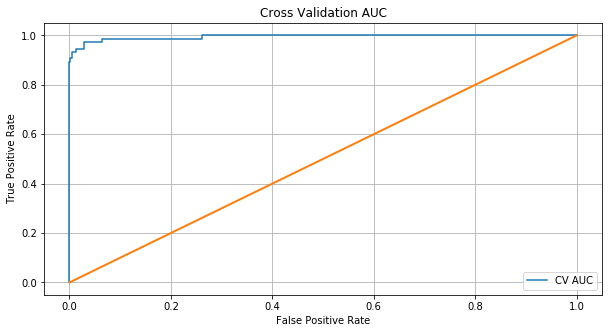

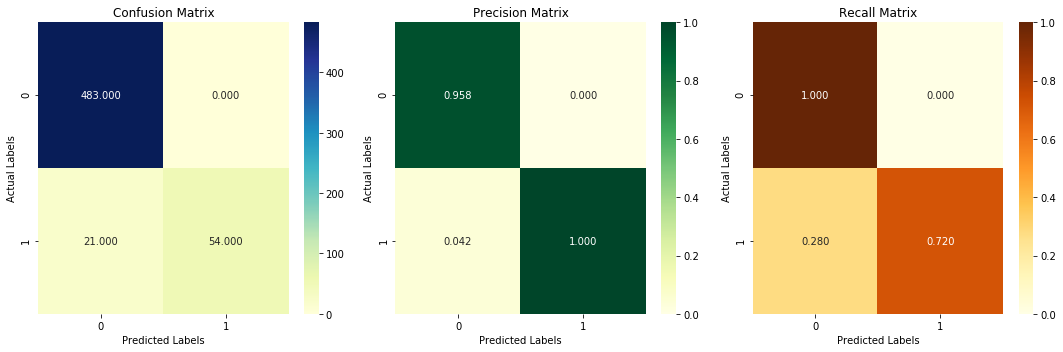

Important features are : 
Feature  ::  presence_of_digit
Feature  ::  text_length
Feature  ::  txt
Feature  ::  call
Feature  ::  free
Feature  ::  claim
Feature  ::  www
Feature  ::  mobile
Feature  ::  150p
Feature  ::  prize


In [41]:
print("Hyper-parameter Tuning : ")
cv_auc_score = list()
for b_tree in base_trees:
    cv_depth = list()
    for dep in [1, 3, 5, 7, 9]:
        _, _, cv_auc = random_forest_model(x_tr_bow_uni, y_tr, x_cv_bow_uni, y_cv, b_tree, dep)
        print("Base Trees={0} and Max Depth={1}  :: AUC={2}"\
              .format(str(b_tree).ljust(6, ' '), str(dep).ljust(2, ' '), \
                      str(round(cv_auc, 5)).ljust(7, '0') ))
        cv_depth.append((dep, cv_auc))
    index = np.argmax([ x[1] for x in cv_depth ])
    cv_auc_score.append(cv_depth[index])
    
index       = np.argmax([ x[1] for x in cv_auc_score ])
best_b_tree = base_trees[index]
best_depth  = cv_auc_score[index][0]
print("\n\nBest auc was found to be for Base Tree={0} and Max Depth={1}, with value to be {1}"\
      .format(best_b_tree, best_depth, str(round(max([x[1] for x in cv_auc_score]), 5)).ljust(7, '0') ))

_  , _      , tr_auc = random_forest_model(x_tr_bow_uni, y_tr, x_tr_bow_uni, y_tr, best_b_tree, best_depth)
_  , _      , cv_auc = random_forest_model(x_tr_bow_uni, y_tr, x_cv_bow_uni, y_cv, best_b_tree, best_depth)
clf, te_pred, te_auc = random_forest_model(x_tr_bow_uni, y_tr, x_te_bow_uni, y_te, best_b_tree, best_depth)
print("\nTest AUC={0} for Base Trees={1} with Max Depth={2}"\
      .format(  str(round(te_auc, 5)).ljust(7, '0'), \
              str(best_b_tree).ljust(5, ' '), str(best_depth).ljust(3, ' ') ))
model_performances['Random Forest (Uni-BoW)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_bow_uni)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(uni_bow_features, clf.feature_importances_)).items()), \
                      reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.2.2] Random Forest : Bi-gram BoW

Hyper-parameter Tuning : 
Base Trees=20     and Max Depth=1   :: AUC=0.50000
Base Trees=20     and Max Depth=3   :: AUC=0.53358
Base Trees=20     and Max Depth=5   :: AUC=0.60448
Base Trees=20     and Max Depth=7   :: AUC=0.67537
Base Trees=20     and Max Depth=9   :: AUC=0.72761
Base Trees=50     and Max Depth=1   :: AUC=0.50000
Base Trees=50     and Max Depth=3   :: AUC=0.51119
Base Trees=50     and Max Depth=5   :: AUC=0.57836
Base Trees=50     and Max Depth=7   :: AUC=0.67164
Base Trees=50     and Max Depth=9   :: AUC=0.75746
Base Trees=100    and Max Depth=1   :: AUC=0.50000
Base Trees=100    and Max Depth=3   :: AUC=0.51493
Base Trees=100    and Max Depth=5   :: AUC=0.56343
Base Trees=100    and Max Depth=7   :: AUC=0.66045
Base Trees=100    and Max Depth=9   :: AUC=0.73134
Base Trees=200    and Max Depth=1   :: AUC=0.50000
Base Trees=200    and Max Depth=3   :: AUC=0.51119
Base Trees=200    and Max Depth=5   :: AUC=0.56343
Base Trees=200    and Max Depth=7   :: AUC=0.66045
Base 

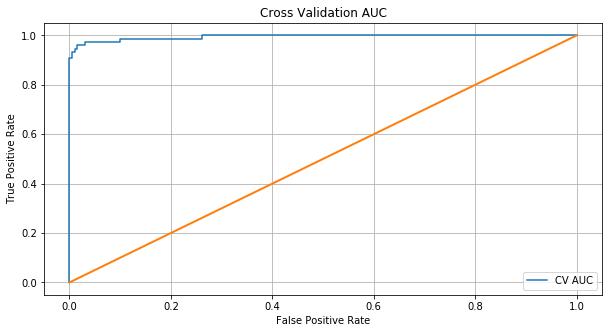

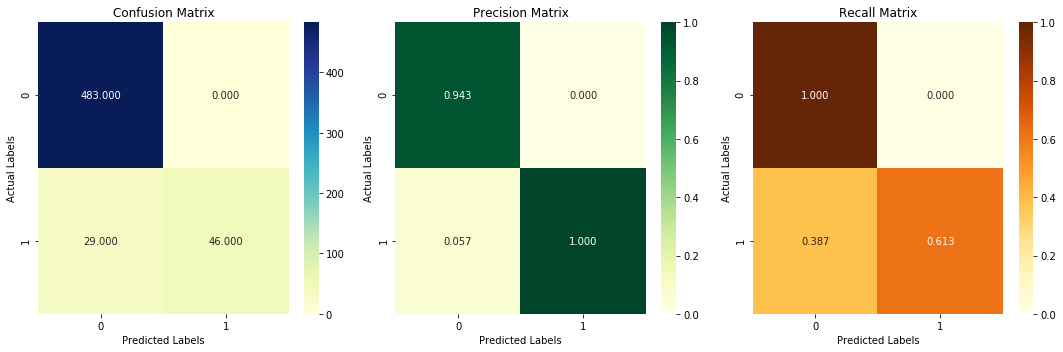

Important features are : 
Feature  ::  presence_of_digit
Feature  ::  text_length
Feature  ::  call
Feature  ::  free
Feature  ::  txt
Feature  ::  claim
Feature  ::  www
Feature  ::  mobile
Feature  ::  prize
Feature  ::  150p


In [42]:
print("Hyper-parameter Tuning : ")
cv_auc_score = list()
for b_tree in base_trees:
    cv_depth = list()
    for dep in [1, 3, 5, 7, 9]:
        _, _, cv_auc = random_forest_model(x_tr_bow_bi, y_tr, x_cv_bow_bi, y_cv, b_tree, dep)
        print("Base Trees={0} and Max Depth={1}  :: AUC={2}"\
              .format(str(b_tree).ljust(6, ' '), str(dep).ljust(2, ' '), \
                      str(round(cv_auc, 5)).ljust(7, '0') ))
        cv_depth.append((dep, cv_auc))
    index = np.argmax([ x[1] for x in cv_depth ])
    cv_auc_score.append(cv_depth[index])
    
index       = np.argmax([ x[1] for x in cv_auc_score ])
best_b_tree = base_trees[index]
best_depth  = cv_auc_score[index][0]
print("\n\nBest auc was found to be for Base Tree={0} and Max Depth={1}, with value to be {1}"\
      .format(best_b_tree, best_depth, str(round(max([x[1] for x in cv_auc_score]), 5)).ljust(7, '0') ))

_  , _      , tr_auc = random_forest_model(x_tr_bow_bi, y_tr, x_tr_bow_bi, y_tr, best_b_tree, best_depth)
_  , _      , cv_auc = random_forest_model(x_tr_bow_bi, y_tr, x_cv_bow_bi, y_cv, best_b_tree, best_depth)
clf, te_pred, te_auc = random_forest_model(x_tr_bow_bi, y_tr, x_te_bow_bi, y_te, best_b_tree, best_depth)
print("\nTest AUC={0} for Base Trees={1} with Max Depth={2}"\
      .format(  str(round(te_auc, 5)).ljust(7, '0'), \
              str(best_b_tree).ljust(5, ' '), str(best_depth).ljust(3, ' ') ))
model_performances['Random Forest (Bi-BoW)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_bow_bi)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(bi_bow_features, clf.feature_importances_)).items()), \
                      reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.3.3] Random Forest : Uni-gram TF-IDF

Hyper-parameter Tuning : 
Base Trees=20     and Max Depth=1   :: AUC=0.50000
Base Trees=20     and Max Depth=3   :: AUC=0.51493
Base Trees=20     and Max Depth=5   :: AUC=0.67910
Base Trees=20     and Max Depth=7   :: AUC=0.77985
Base Trees=20     and Max Depth=9   :: AUC=0.84328
Base Trees=50     and Max Depth=1   :: AUC=0.50000
Base Trees=50     and Max Depth=3   :: AUC=0.50000
Base Trees=50     and Max Depth=5   :: AUC=0.63060
Base Trees=50     and Max Depth=7   :: AUC=0.79478
Base Trees=50     and Max Depth=9   :: AUC=0.83955
Base Trees=100    and Max Depth=1   :: AUC=0.50000
Base Trees=100    and Max Depth=3   :: AUC=0.50000
Base Trees=100    and Max Depth=5   :: AUC=0.63060
Base Trees=100    and Max Depth=7   :: AUC=0.77985
Base Trees=100    and Max Depth=9   :: AUC=0.83955
Base Trees=200    and Max Depth=1   :: AUC=0.50000
Base Trees=200    and Max Depth=3   :: AUC=0.50000
Base Trees=200    and Max Depth=5   :: AUC=0.60821
Base Trees=200    and Max Depth=7   :: AUC=0.74627
Base 

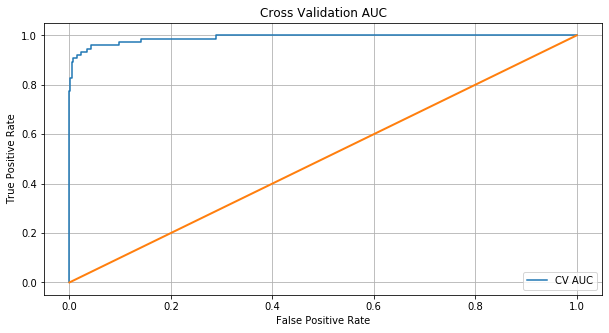

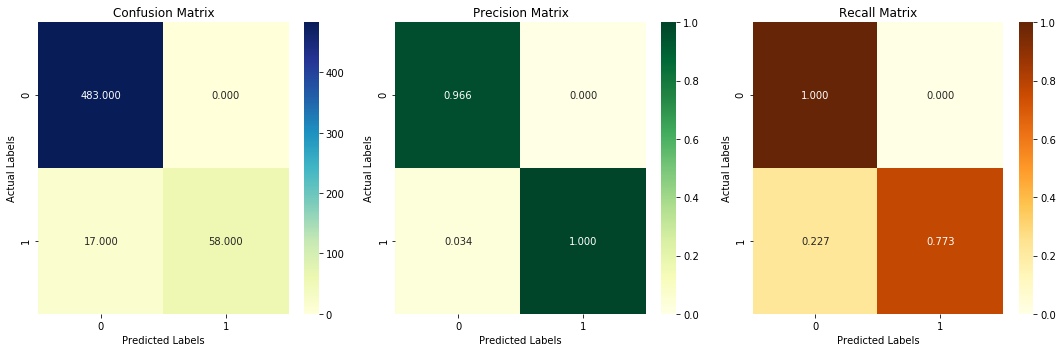

Important features are : 
Feature  ::  presence_of_digit
Feature  ::  text_length
Feature  ::  call
Feature  ::  txt
Feature  ::  mobile
Feature  ::  your
Feature  ::  reply
Feature  ::  www
Feature  ::  16
Feature  ::  text


In [43]:
print("Hyper-parameter Tuning : ")
cv_auc_score = list()
for b_tree in base_trees:
    cv_depth = list()
    for dep in [1, 3, 5, 7, 9]:
        _, _, cv_auc = random_forest_model(x_tr_tfidf_uni, y_tr, x_cv_tfidf_uni, y_cv, b_tree, dep)
        print("Base Trees={0} and Max Depth={1}  :: AUC={2}"\
              .format(str(b_tree).ljust(6, ' '), str(dep).ljust(2, ' '), \
                      str(round(cv_auc, 5)).ljust(7, '0') ))
        cv_depth.append((dep, cv_auc))
    index = np.argmax([ x[1] for x in cv_depth ])
    cv_auc_score.append(cv_depth[index])
    
index       = np.argmax([ x[1] for x in cv_auc_score ])
best_b_tree = base_trees[index]
best_depth  = cv_auc_score[index][0]
print("\n\nBest auc was found to be for Base Tree={0} and Max Depth={1}, with value to be {1}"\
      .format(best_b_tree, best_depth, str(round(max([x[1] for x in cv_auc_score]), 5)).ljust(7, '0') ))

_  , _      , tr_auc = random_forest_model(x_tr_tfidf_uni, y_tr, x_tr_tfidf_uni, y_tr, best_b_tree, best_depth)
_  , _      , cv_auc = random_forest_model(x_tr_tfidf_uni, y_tr, x_cv_tfidf_uni, y_cv, best_b_tree, best_depth)
clf, te_pred, te_auc = random_forest_model(x_tr_tfidf_uni, y_tr, x_te_tfidf_uni, y_te, best_b_tree, best_depth)
print("\nTest AUC={0} for Base Trees={1} with Max Depth={2}"\
      .format(  str(round(te_auc, 5)).ljust(7, '0'), \
              str(best_b_tree).ljust(5, ' '), str(best_depth).ljust(3, ' ') ))
model_performances['Random Forest (Uni-TF-IDF)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_tfidf_uni)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(uni_tfidf_features, clf.feature_importances_)).items()), \
                      reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.3.4] Random Forest : Bi-gram TF-IDF

Hyper-parameter Tuning : 
Base Trees=20     and Max Depth=1   :: AUC=0.50000
Base Trees=20     and Max Depth=3   :: AUC=0.53731
Base Trees=20     and Max Depth=5   :: AUC=0.58582
Base Trees=20     and Max Depth=7   :: AUC=0.68657
Base Trees=20     and Max Depth=9   :: AUC=0.77239
Base Trees=50     and Max Depth=1   :: AUC=0.50000
Base Trees=50     and Max Depth=3   :: AUC=0.51119
Base Trees=50     and Max Depth=5   :: AUC=0.57463
Base Trees=50     and Max Depth=7   :: AUC=0.67910
Base Trees=50     and Max Depth=9   :: AUC=0.76493
Base Trees=100    and Max Depth=1   :: AUC=0.50000
Base Trees=100    and Max Depth=3   :: AUC=0.51493
Base Trees=100    and Max Depth=5   :: AUC=0.56716
Base Trees=100    and Max Depth=7   :: AUC=0.66418
Base Trees=100    and Max Depth=9   :: AUC=0.75000
Base Trees=200    and Max Depth=1   :: AUC=0.50000
Base Trees=200    and Max Depth=3   :: AUC=0.50746
Base Trees=200    and Max Depth=5   :: AUC=0.56343
Base Trees=200    and Max Depth=7   :: AUC=0.65672
Base 

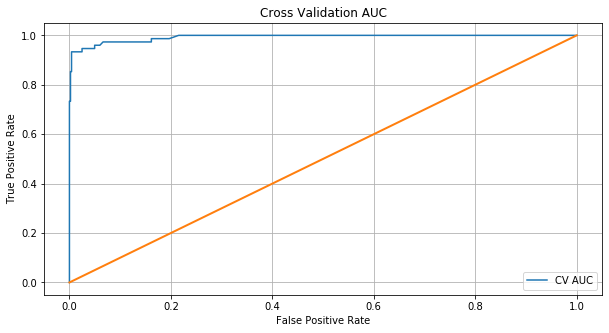

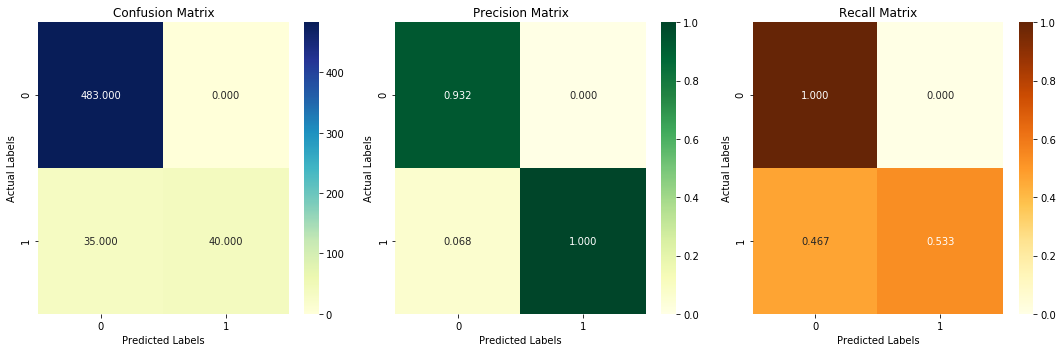

Important features are : 
Feature  ::  presence_of_digit
Feature  ::  text_length
Feature  ::  free
Feature  ::  prize
Feature  ::  claim
Feature  ::  call
Feature  ::  txt
Feature  ::  18
Feature  ::  now
Feature  ::  reply


In [44]:
print("Hyper-parameter Tuning : ")
cv_auc_score = list()
for b_tree in base_trees:
    cv_depth = list()
    for dep in [1, 3, 5, 7, 9]:
        _, _, cv_auc = random_forest_model(x_tr_tfidf_bi, y_tr, x_cv_tfidf_bi, y_cv, b_tree, dep)
        print("Base Trees={0} and Max Depth={1}  :: AUC={2}"\
              .format(str(b_tree).ljust(6, ' '), str(dep).ljust(2, ' '), \
                      str(round(cv_auc, 5)).ljust(7, '0') ))
        cv_depth.append((dep, cv_auc))
    index = np.argmax([ x[1] for x in cv_depth ])
    cv_auc_score.append(cv_depth[index])
    
index       = np.argmax([ x[1] for x in cv_auc_score ])
best_b_tree = base_trees[index]
best_depth  = cv_auc_score[index][0]
print("\n\nBest auc was found to be for Base Tree={0} and Max Depth={1}, with value to be {1}"\
      .format(best_b_tree, best_depth, str(round(max([x[1] for x in cv_auc_score]), 5)).ljust(7, '0') ))

_  , _      , tr_auc = random_forest_model(x_tr_tfidf_bi, y_tr, x_tr_tfidf_bi, y_tr, best_b_tree, best_depth)
_  , _      , cv_auc = random_forest_model(x_tr_tfidf_bi, y_tr, x_cv_tfidf_bi, y_cv, best_b_tree, best_depth)
clf, te_pred, te_auc = random_forest_model(x_tr_tfidf_bi, y_tr, x_te_tfidf_bi, y_te, best_b_tree, best_depth)
print("\nTest AUC={0} for Base Trees={1} with Max Depth={2}"\
      .format(  str(round(te_auc, 5)).ljust(7, '0'), \
              str(best_b_tree).ljust(5, ' '), str(best_depth).ljust(3, ' ') ))
model_performances['Random Forest (Bi-TF-IDF)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_tfidf_bi)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(bi_tfidf_features, clf.feature_importances_)).items()), \
                      reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.3.5] Random Forest : Avg. Word2Vec

Hyper-parameter Tuning : 
Base Trees=20     and Max Depth=1   :: AUC=0.50000
Base Trees=20     and Max Depth=3   :: AUC=0.74397
Base Trees=20     and Max Depth=5   :: AUC=0.85361
Base Trees=20     and Max Depth=7   :: AUC=0.89666
Base Trees=20     and Max Depth=9   :: AUC=0.92565
Base Trees=50     and Max Depth=1   :: AUC=0.50000
Base Trees=50     and Max Depth=3   :: AUC=0.67480
Base Trees=50     and Max Depth=5   :: AUC=0.87054
Base Trees=50     and Max Depth=7   :: AUC=0.90354
Base Trees=50     and Max Depth=9   :: AUC=0.93196
Base Trees=100    and Max Depth=1   :: AUC=0.50000
Base Trees=100    and Max Depth=3   :: AUC=0.65299
Base Trees=100    and Max Depth=5   :: AUC=0.85734
Base Trees=100    and Max Depth=7   :: AUC=0.90785
Base Trees=100    and Max Depth=9   :: AUC=0.92450
Base Trees=200    and Max Depth=1   :: AUC=0.50000
Base Trees=200    and Max Depth=3   :: AUC=0.70665
Base Trees=200    and Max Depth=5   :: AUC=0.85619
Base Trees=200    and Max Depth=7   :: AUC=0.91158
Base 

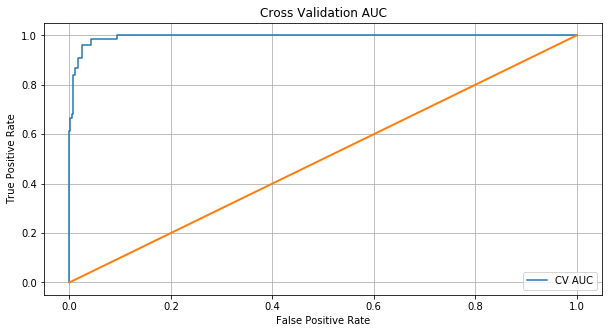

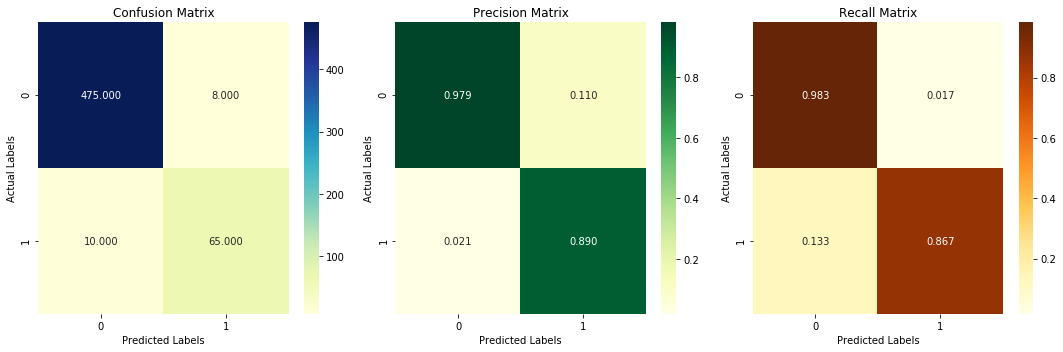

Important features are : 
Feature  ::  presence_of_digit
Feature  ::  text_length
Feature  ::  w2v_dim_081
Feature  ::  w2v_dim_065
Feature  ::  w2v_dim_014
Feature  ::  w2v_dim_039
Feature  ::  w2v_dim_067
Feature  ::  w2v_dim_077
Feature  ::  w2v_dim_084
Feature  ::  w2v_dim_006


In [45]:
print("Hyper-parameter Tuning : ")
cv_auc_score = list()
for b_tree in base_trees:
    cv_depth = list()
    for dep in [1, 3, 5, 7, 9]:
        _, _, cv_auc = random_forest_model(x_tr_w2v, y_tr, x_cv_w2v, y_cv, b_tree, dep)
        print("Base Trees={0} and Max Depth={1}  :: AUC={2}"\
              .format(str(b_tree).ljust(6, ' '), str(dep).ljust(2, ' '), \
                      str(round(cv_auc, 5)).ljust(7, '0') ))
        cv_depth.append((dep, cv_auc))
    index = np.argmax([ x[1] for x in cv_depth ])
    cv_auc_score.append(cv_depth[index])
    
index       = np.argmax([ x[1] for x in cv_auc_score ])
best_b_tree = base_trees[index]
best_depth  = cv_auc_score[index][0]
print("\n\nBest auc was found to be for Base Tree={0} and Max Depth={1}, with value to be {1}"\
      .format(best_b_tree, best_depth, str(round(max([x[1] for x in cv_auc_score]), 5)).ljust(7, '0') ))

_  , _      , tr_auc = random_forest_model(x_tr_w2v, y_tr, x_tr_w2v, y_tr, best_b_tree, best_depth)
_  , _      , cv_auc = random_forest_model(x_tr_w2v, y_tr, x_cv_w2v, y_cv, best_b_tree, best_depth)
clf, te_pred, te_auc = random_forest_model(x_tr_w2v, y_tr, x_te_w2v, y_te, best_b_tree, best_depth)
print("\nTest AUC={0} for Base Trees={1} with Max Depth={2}"\
      .format(  str(round(te_auc, 5)).ljust(7, '0'), \
              str(best_b_tree).ljust(5, ' '), str(best_depth).ljust(3, ' ') ))
model_performances['Random Forest (Avg.W2V)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_w2v)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(w2v_features, clf.feature_importances_)).items()), \
                      reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

#### [3.3.6] Random Forest : TF-IDF Word2Vec

Hyper-parameter Tuning : 
Base Trees=20     and Max Depth=1   :: AUC=0.50000
Base Trees=20     and Max Depth=3   :: AUC=0.63433
Base Trees=20     and Max Depth=5   :: AUC=0.84156
Base Trees=20     and Max Depth=7   :: AUC=0.88546
Base Trees=20     and Max Depth=9   :: AUC=0.91503
Base Trees=50     and Max Depth=1   :: AUC=0.50000
Base Trees=50     and Max Depth=3   :: AUC=0.60075
Base Trees=50     and Max Depth=5   :: AUC=0.83409
Base Trees=50     and Max Depth=7   :: AUC=0.90011
Base Trees=50     and Max Depth=9   :: AUC=0.91992
Base Trees=100    and Max Depth=1   :: AUC=0.50000
Base Trees=100    and Max Depth=3   :: AUC=0.57090
Base Trees=100    and Max Depth=5   :: AUC=0.83294
Base Trees=100    and Max Depth=7   :: AUC=0.89580
Base Trees=100    and Max Depth=9   :: AUC=0.91618
Base Trees=200    and Max Depth=1   :: AUC=0.50000
Base Trees=200    and Max Depth=3   :: AUC=0.58582
Base Trees=200    and Max Depth=5   :: AUC=0.84041
Base Trees=200    and Max Depth=7   :: AUC=0.89638
Base 

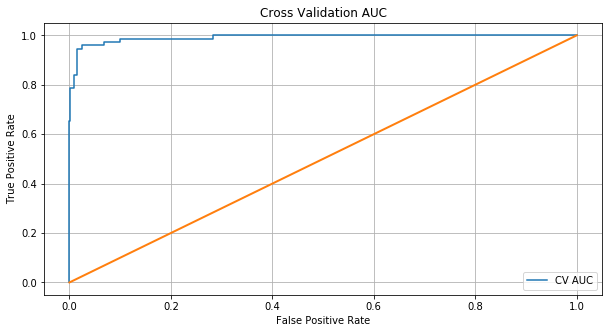

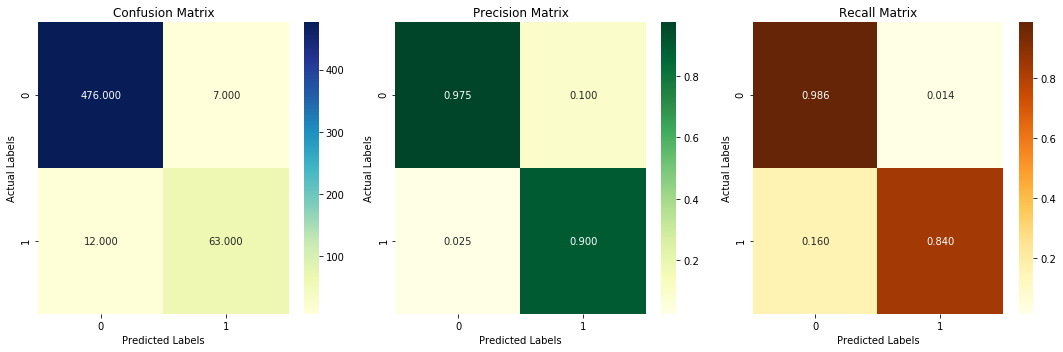

Important features are : 
Feature  ::  presence_of_digit
Feature  ::  text_length
Feature  ::  tfidfw2v_dim_081
Feature  ::  tfidfw2v_dim_065
Feature  ::  tfidfw2v_dim_014
Feature  ::  tfidfw2v_dim_098
Feature  ::  tfidfw2v_dim_067
Feature  ::  tfidfw2v_dim_094
Feature  ::  tfidfw2v_dim_035
Feature  ::  tfidfw2v_dim_084


In [46]:
print("Hyper-parameter Tuning : ")
cv_auc_score = list()
for b_tree in base_trees:
    cv_depth = list()
    for dep in [1, 3, 5, 7, 9]:
        _, _, cv_auc = random_forest_model(x_tr_tfidfw2v, y_tr, x_cv_tfidfw2v, y_cv, b_tree, dep)
        print("Base Trees={0} and Max Depth={1}  :: AUC={2}"\
              .format(str(b_tree).ljust(6, ' '), str(dep).ljust(2, ' '), \
                      str(round(cv_auc, 5)).ljust(7, '0') ))
        cv_depth.append((dep, cv_auc))
    index = np.argmax([ x[1] for x in cv_depth ])
    cv_auc_score.append(cv_depth[index])
    
index       = np.argmax([ x[1] for x in cv_auc_score ])
best_b_tree = base_trees[index]
best_depth  = cv_auc_score[index][0]
print("\n\nBest auc was found to be for Base Tree={0} and Max Depth={1}, with value to be {1}"\
      .format(best_b_tree, best_depth, str(round(max([x[1] for x in cv_auc_score]), 5)).ljust(7, '0') ))

_  , _      , tr_auc = random_forest_model(x_tr_tfidfw2v, y_tr, x_tr_tfidfw2v, y_tr, best_b_tree, best_depth)
_  , _      , cv_auc = random_forest_model(x_tr_tfidfw2v, y_tr, x_cv_tfidfw2v, y_cv, best_b_tree, best_depth)
clf, te_pred, te_auc = random_forest_model(x_tr_tfidfw2v, y_tr, x_te_tfidfw2v, y_te, best_b_tree, best_depth)
print("\nTest AUC={0} for Base Trees={1} with Max Depth={2}"\
      .format(  str(round(te_auc, 5)).ljust(7, '0'), \
              str(best_b_tree).ljust(5, ' '), str(best_depth).ljust(3, ' ') ))
model_performances['Random Forest (TF-IDF W2V)'] = [best_alpha, tr_auc, cv_auc, te_auc]
tr_pred_probs = clf.predict_proba(x_te_tfidfw2v)[:,1]
plot_confusion_matrix(y_te, te_pred, tr_pred_probs)


print("Important features are : ")
imp_features = sorted(list(dict(zip(tfidfw2v_features, clf.feature_importances_)).items()), \
                      reverse=True, key=lambda x:x[1])[:max_features]
for i in imp_features:
    print("Feature  :: ",i[0])

In [47]:
from prettytable import PrettyTable

rf = PrettyTable(['Model', 'Best Hyper-parameter', 'Train AUC', 'CV AUC', 'Test AUC'])
for k, v in list(model_performances.items()):
    if k.startswith('Random Forest'):
        rf.add_row([k, v[0], round(v[1], 5), round(v[2], 5), round(v[3], 5)])
    
print(rf)

+----------------------------+----------------------+-----------+---------+----------+
|           Model            | Best Hyper-parameter | Train AUC |  CV AUC | Test AUC |
+----------------------------+----------------------+-----------+---------+----------+
|  Random Forest (Uni-BoW)   |        1e-05         |  0.83086  | 0.82836 |   0.86   |
|   Random Forest (Bi-BoW)   |        1e-05         |  0.78532  | 0.76493 | 0.80667  |
| Random Forest (Uni-TF-IDF) |        1e-05         |  0.86431  | 0.84328 | 0.88667  |
| Random Forest (Bi-TF-IDF)  |        1e-05         |  0.79089  | 0.77239 | 0.76667  |
|  Random Forest (Avg.W2V)   |        1e-05         |  0.97712  | 0.93196 | 0.92505  |
| Random Forest (TF-IDF W2V) |        1e-05         |  0.97476  |  0.9225 | 0.91275  |
+----------------------------+----------------------+-----------+---------+----------+


<p><b>Conclusion : Random Forest Model</b></p>

<p>From above AUC plots and Confusion MAtrics, we can see that Random Forest model performs better but the auc score we get is very less compared to what we get with Naive Bayes Classifier. AUC score of more than 0.86 is obtained in both Unigram BoW and TF-IDF vectorization techniques. Lower AUC score was obtained with Bi-gram BoW and TFIDF vectorization techniques.</p>
<p>Word2vector techniques tend to give higher value of AUC which is more than 0.91.</p>

# [4] Conclusion

In [52]:
from prettytable import PrettyTable

sms_spam = PrettyTable(['Model', 'Best Hyper-parameter', 'Train AUC', 'CV AUC', 'Test AUC'])
for k, v in list(model_performances.items()):
    sms_spam.add_row([k.center(30, ' '), v[0], round(v[1], 5), round(v[2], 5), round(v[3], 5)])
    
print(sms_spam)

+--------------------------------+----------------------+-----------+---------+----------+
|             Model              | Best Hyper-parameter | Train AUC |  CV AUC | Test AUC |
+--------------------------------+----------------------+-----------+---------+----------+
|     Naive Bayes (Uni-BOW)      |        0.0001        |  0.98018  | 0.97301 |   0.98   |
|      Naive Bayes (Bi-BOW)      |         0.1          |  0.97461  | 0.96727 | 0.99126  |
|    Naive Bayes (Uni-TF-IDF)    |        0.001         |  0.97031  | 0.97215 |  0.9846  |
|     Naive Bayes (Bi-TFIDF)     |        0.001         |  0.97425  | 0.96842 |  0.9846  |
|       Log-Reg (Uni-BoW)        |        0.0001        |  0.99521  | 0.96842 | 0.97275  |
|        Log-Reg (Bi-BoW)        |        0.0001        |  0.99628  | 0.96842 | 0.97275  |
|      Log-Reg (Uni-TF-IDF)      |        1e-05         |  0.99692  |  0.9667 | 0.97586  |
|      Log-Reg (Bi-TF-IDF)       |        1e-06         |  0.99907  | 0.96785 | 0.97586  |

<p>
    We used three Machine Learning Models for classification of SMS into Ham or Spam.
    <li>Naive Bayes</li>
    <li>Logistic Regression</li>
    <li>Tree based Random Forest Model</li>
</p>
<p>
    Models are trained with Text Vectorization techniques like Bag of Words, TF-IDF vectorizer and Word Vector.
</p>
<p>With above vectorization, best model performance was given by Naive Bayes with Binary Bag of Words vectorization technique.</p>

<hr>